```
NAME : SAPTARSHI GHOSH
ROLL NO. : 002211001122
SECTION : A3
DATE : 19/10/2025
B.E. INFORMATION TECHNOLOGY 2022-26
```
##**MACHINE LEARNING LAB ASSIGNMENT 4**

1: Apply the below clustering algorithms using Python:
   * **Partition based: K-means, K-medoids/PAM**
   * **Hierarchical: Dendrogram**
   * **Density based: DBSCAN, OPTICS**

  on the following UCI datasets (can be loaded from the package itself):
  - Iris plants dataset: https://archive.ics.uci.edu/ml/datasets/Iris/
  - Wine Dataset: https://archive.ics.uci.edu/ml/datasets/wine

Additionally, implement K-means++ and Bisecting K-means.

2: Evaluate and compare the performances of the algorithms for each type of clustering, based
on the following metrics:
- **Rand index**: rand score, adjusted rand score
- **Mutual Information based scores**: mutual info, adjusted mutual info, normalized
mutual info
- **Silhouette Coefficient, Calinski-Harabasz Index and Davies-Bouldin Index**

During evaluation, replace the class/category names with numerical values starting from 0, 1, 2, ...

3: Also determine the Cohesion and Separation performance scores using **Sum of Squared Error (SSE)** **and Sum of Squares Between groups (SSB)**.

Try to achieve accuracy >=80%.
Show the performance comparison for each category of clustering algorithms in a tabular form.

---

## **1. Importing Libraries and Setup**

### **Import Required Libraries**

In [ ]:
!pip install ucimlrepo numpy==1.26.4 scikit-learn-extra

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (
adjusted_rand_score, rand_score, adjusted_mutual_info_score,
mutual_info_score, normalized_mutual_info_score, silhouette_score,
calinski_harabasz_score, davies_bouldin_score
)
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, OPTICS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import pairwise_distances
from sklearn_extra.cluster import KMedoids

## **2. Common Utility Functions**

###**Data Loading and Preprocessing Function**

In [ ]:
def load_and_preprocess_ucirepo(dataset_id, target_col='class', standardize=True, plot_pairplot=True):

    # Fetch dataset
    data = fetch_ucirepo(id=dataset_id)
    X_df = data.data.features
    y_df = data.data.targets

    print("Dataset loaded successfully!")
    print("Shape of features:", X_df.shape)
    print("Unique classes:", y_df[target_col].unique())

    # Encode target labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_df[target_col])
    print("Encoded labels:", np.unique(y_encoded))

    # Basic EDA
    print("\nFirst 5 rows of the dataset:")
    display(X_df.head())

    # Pairplot visualization
    if plot_pairplot:
        sns.pairplot(pd.concat([X_df, y_df], axis=1), hue=target_col)
        plt.suptitle(f"Pairwise Relationships in Dataset ID {dataset_id}", y=1.02)
        plt.show()

    # Standardize features
    X_scaled = X_df.values
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_scaled)

    return X_scaled, y_encoded

The `load_and_preprocess_ucirepo()` function provides a consistent and robust preprocessing pipeline for applying clustering algorithms to UCI datasets such as IRIS and WINE.

It begins by fetching the dataset, separating the features and target column, and using `LabelEncoder` to convert categorical class labels (like "setosa", "versicolor", "virginica") into numeric codes (0, 1, 2). Although clustering is unsupervised, this encoding is essential for computing evaluation metrics such as Adjusted Rand Index or Normalized Mutual Information, which require numerical labels.

The function also applies `StandardScaler` to standardize the feature matrix, transforming each feature to have zero mean and unit variance. This step is critical because distance-based clustering algorithms (like K-Means, DBSCAN, and hierarchical methods) are sensitive to feature magnitudes. Without scaling, features with larger ranges would dominate the distance computation, distorting cluster geometry. Standardization ensures equal contribution of all features, improves numerical stability, and enhances the accuracy and comparability of clustering results.

Finally, the optional pairplot visualization supports exploratory data analysis by revealing potential separability and feature relationships before clustering.

### **Visualisation Functions**

In [ ]:
def plot_pca_2d(X, labels, title=''):

    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)

    my_colors = ['#F5F749', '#FF1B1C', '#5AA9E6', '#447604', '#94B9AF']
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels, palette=my_colors, s=80, alpha=0.8)

    plt.title(title + ' (PCA 2D)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster')
    # plt.show()

### **Evaluation Metrics Function**

In [ ]:
def evaluate_clustering(X, y_true, y_pred, algorithm_name="Algorithm", include_internal=True):
    metrics = {}
    metrics["Algorithm"] = algorithm_name

    # External metrics (need ground truth)
    metrics["Rand Index"] = rand_score(y_true, y_pred)
    metrics["Adjusted Rand Index"] = adjusted_rand_score(y_true, y_pred)
    metrics["Mutual Information"] = mutual_info_score(y_true, y_pred)
    metrics["Normalized MI"] = normalized_mutual_info_score(y_true, y_pred)

    # Internal metrics (based on X and cluster structure)
    if include_internal:
        # Remove noise points (-1) for internal metrics
        mask = y_pred != -1
        X_valid = X[mask]
        y_valid = y_pred[mask]

        if len(set(y_valid)) > 1:
            metrics["Silhouette Score"] = silhouette_score(X_valid, y_valid)
            metrics["Calinski-Harabasz"] = calinski_harabasz_score(X_valid, y_valid)
            metrics["Davies-Bouldin"] = davies_bouldin_score(X_valid, y_valid)
        else:
            metrics["Silhouette Score"] = None
            metrics["Calinski-Harabasz"] = None
            metrics["Davies-Bouldin"] = None

    print(f"\nClustering Evaluation Metrics for {algorithm_name}:")
    for k, v in metrics.items():
        if k == "Algorithm":
            continue
        if isinstance(v, (int, float, np.floating)):
            print(f"{k:25s}: {v if not np.isnan(v) else 'Not Applicable'}")
        else:
            print(f"{k:25s}: {v if v is not None else 'Not Applicable'}")

    return pd.DataFrame([metrics])

External metrics — such as Rand Index, Adjusted Rand Index (ARI), Mutual Information (MI), and Normalized Mutual Information (NMI) — compare the predicted cluster labels (y_pred) against the known ground truth (y_true). These metrics measure how well the clustering reproduces the actual class distribution, making them ideal for benchmark datasets like Iris and Wine, where true labels are available. For example, ARI adjusts for chance grouping, and NMI accounts for the shared information between true and predicted labels. However, in real-world unsupervised settings where ground truth is unknown, external metrics cannot be used.

Internal metrics, on the other hand, evaluate clustering quality solely based on the input data (X) and the resulting cluster structure, without requiring true labels. These include Silhouette Score, Calinski–Harabasz Index, and Davies–Bouldin Index. They assess intra-cluster cohesion and inter-cluster separation — for instance, a high Silhouette Score indicates well-separated, dense clusters. Internal metrics are crucial in true unsupervised scenarios, where no labeled data exists, and one needs to compare clustering algorithms or parameter settings based purely on structural validity.

In summary, external metrics are more interpretable and reliable when true labels are available (e.g., for evaluating algorithm performance on benchmark datasets), while internal metrics are indispensable in practical clustering applications where such labels are absent, helping to determine the optimal clustering configuration and overall model quality.

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances

def compute_sse_ssb(X, labels):
    # Cohesion (SSE): Sum of squared distances within clusters
    overall_mean = np.mean(X, axis=0)
    unique_labels = np.unique(labels)
    sse = 0
    ssb = 0
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        if len(cluster_points) == 0:
            continue
        centroid = np.mean(cluster_points, axis=0)
        sse += np.sum((cluster_points - centroid) ** 2)
        ssb += len(cluster_points) * np.sum((centroid - overall_mean) ** 2)
    return sse, ssb

### **Clustering Algorithm Runners**

#### **K-Means Clustering**

In [ ]:
def run_kmeans(X, y=None, n_clusters=3, random_state=42):
    model = KMeans(n_clusters=n_clusters, random_state=random_state, init='random')
    y_pred = model.fit_predict(X)

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="KMeans")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="K-Means Clustering")

    pca = PCA(n_components=2)
    Z = pca.fit_transform(X_scaled)
    centroids_pca = pca.transform(model.cluster_centers_)

    plt.scatter(
        centroids_pca[:, 0],
        centroids_pca[:, 1],
        marker='x',
        s=100,
        linewidths=4,
        color='r',
        zorder=10
    )
    plt.legend()
    plt.show()

    return y_pred, model

#### **K-Means Clustering with K-Means++ Initialisation**

In [ ]:
def run_kmeans_plus(X, y=None, n_clusters=3, random_state=42):
    model = KMeans(n_clusters=n_clusters, random_state=random_state, init='k-means++')
    y_pred = model.fit_predict(X)

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="KMeans++")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="K-Means++ Clustering")

    pca = PCA(n_components=2)
    Z = pca.fit_transform(X_scaled)
    centroids_pca = pca.transform(model.cluster_centers_)

    plt.scatter(
        centroids_pca[:, 0],
        centroids_pca[:, 1],
        marker='x',
        s=100,
        linewidths=4,
        color='r',
        zorder=10
    )
    plt.legend()
    plt.show()

    return y_pred, model

#### **K-Medoids Clustering (PAM)**

In [ ]:
def run_kmedoids(X, y=None, n_clusters=3, random_state=42):
    model = KMedoids(n_clusters=n_clusters, random_state=random_state, method='pam')
    y_pred = model.fit_predict(X)

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="KMedoids")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="K-Medoids Clustering")

    pca = PCA(n_components=2)
    Z = pca.fit_transform(X_scaled)
    centroids_pca = pca.transform(model.cluster_centers_)

    plt.scatter(
        centroids_pca[:, 0],
        centroids_pca[:, 1],
        marker='x',
        s=100,
        linewidths=4,
        color='r',
        zorder=10
    )
    plt.legend()
    plt.show()
    return y_pred, model

#### **Bisecting K-Means Clustering**

In [ ]:
def run_bisecting_kmeans(X, y=None, n_clusters=3, random_state=42):
    model = BisectingKMeans(n_clusters=n_clusters, random_state=random_state)
    y_pred = model.fit_predict(X)

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="Bisecting KMeans")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="Bisecting K-Means Clustering")

    pca = PCA(n_components=2)
    Z = pca.fit_transform(X_scaled)
    centroids_pca = pca.transform(model.cluster_centers_)

    plt.scatter(
        centroids_pca[:, 0],
        centroids_pca[:, 1],
        marker='x',
        s=100,
        linewidths=4,
        color='r',
        zorder=10
    )
    plt.legend()
    plt.show()
    return y_pred, model

#### **Hierarchical Clustering (Dendrogram)**

In [ ]:
def run_dendrogram(X, y=None, n_clusters=3, method='ward'):
    Z = linkage(X, method=method)

    # Plot dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(Z)
    plt.title(f"Dendrogram ({method} linkage)")
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.show()

    # Form clusters
    y_pred = fcluster(Z, t=n_clusters, criterion='maxclust')

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="Dendrogram")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="Hierarchical Clustering")

    plt.legend()
    plt.show()

    return y_pred, Z

#### **DBSCAN Clustering**

In [ ]:
def run_dbscan(X, y=None, eps=0.01, min_samples=10):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = model.fit_predict(X)

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="DBSCAN")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="DBSCAN Clustering")

    plt.legend()
    plt.show()
    return y_pred, model

#### **OPTICS Clustering**

In [ ]:
def run_optics(X, y=None, min_samples=5, xi=0.07, min_cluster_size=0.05):
    model = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    y_pred = model.fit_predict(X)

    print("===============================================")
    metric = evaluate_clustering(X_scaled, y_encoded, y_pred, algorithm_name="OPTICS")
    print("\n===============================================\n")

    global results
    results = pd.concat([results, metric], ignore_index=True)
    plot_pca_2d(X_scaled, y_pred, title="OPTICS Clustering")

    plt.legend()
    plt.show()
    return y_pred, model

## **3. Clustering on IRIS Dataset**


### **Load and Preprocess Data**

Dataset loaded successfully!
Shape of features: (150, 4)
Unique classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Encoded labels: [0 1 2]

First 5 rows of the dataset:


sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

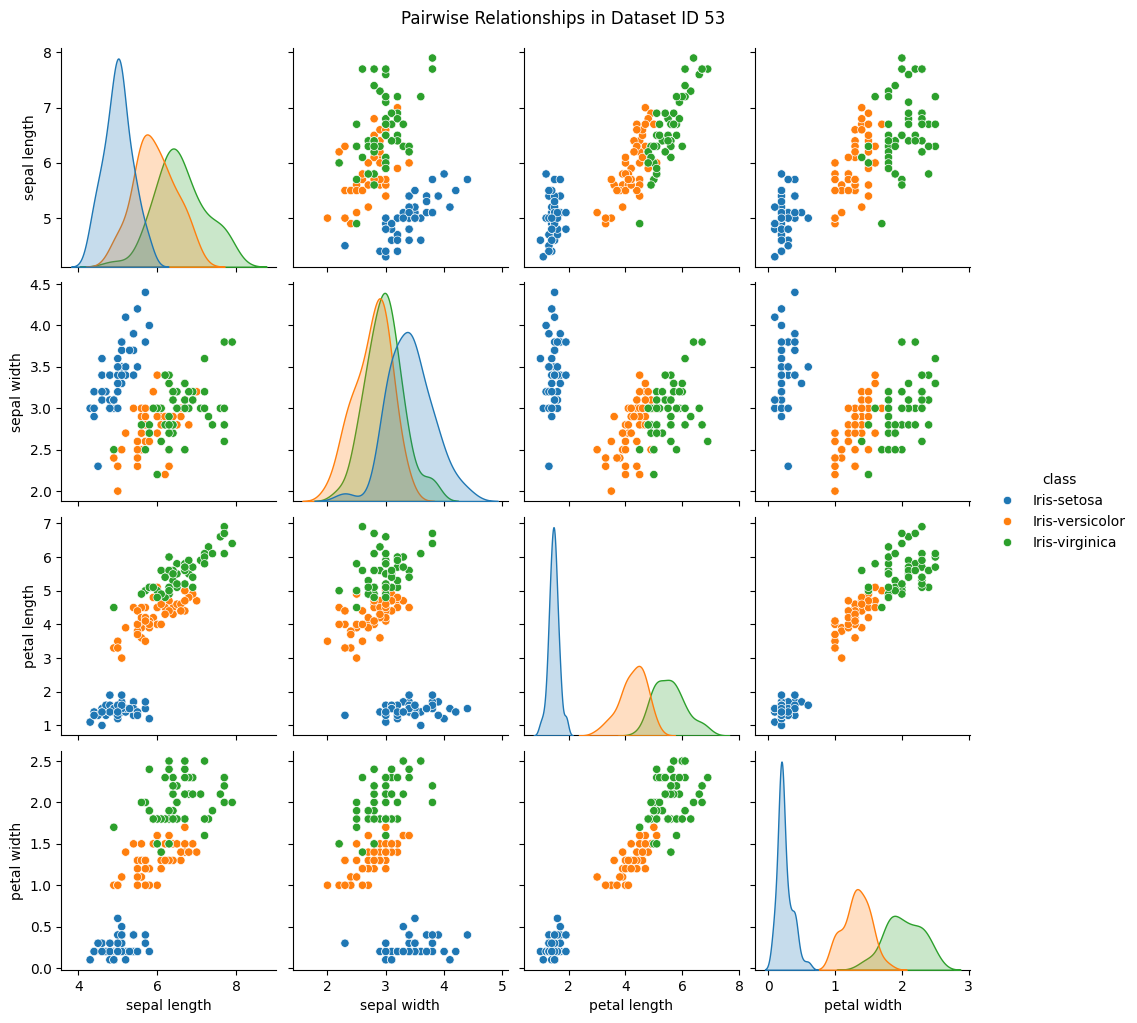

Features shape: (150, 4)
Labels shape: (150,)


In [ ]:
# Load Iris dataset (UCI ID 53)
X_scaled, y_encoded = load_and_preprocess_ucirepo(53)

print("=================================")
print("Features shape:", X_scaled.shape)
print("Labels shape:", y_encoded.shape)
print("=================================")

In [ ]:
# Dataframe to store results
results = pd.DataFrame()

### **Apply Clustering Algorithms**

#### **K-Means Clustering**


Clustering Evaluation Metrics for KMeans:
Rand Index               : 0.8278299776286353
Adjusted Rand Index      : 0.6100728505285608
Mutual Information       : 0.7167343978433044
Normalized MI            : 0.6525582020084985
Silhouette Score         : 0.4584008709907477
Calinski-Harabasz        : 239.33611492789424
Davies-Bouldin           : 0.8358002024712284




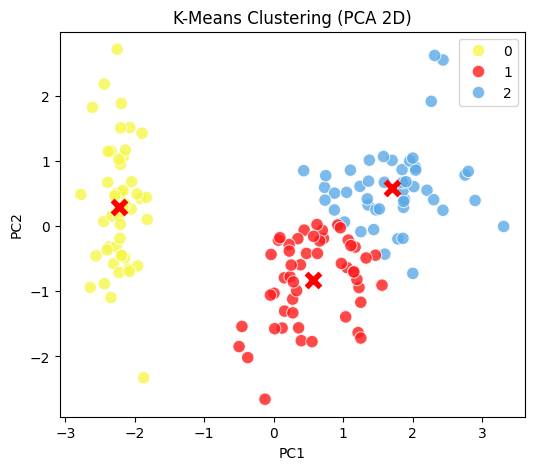

SSE (Within-cluster sum of squares): 140.96837895511078
SSB (Between-cluster sum of squares): 459.031621044889
SSB/SSE ratio: 3.256273672488357


In [ ]:
y_pred, model = run_kmeans(X_scaled, y_encoded, n_clusters=3)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "KMeans", ["SSE", "SSB"]] = [sse, ssb]


#### **K-Means Clustering with K-Means++ Initialisation**


Clustering Evaluation Metrics for KMeans++:
Rand Index               : 0.719731543624161
Adjusted Rand Index      : 0.4289511167236898
Mutual Information       : 0.5860133769462492
Normalized MI            : 0.5873776041729258
Silhouette Score         : 0.4787241921049546
Calinski-Harabasz        : 156.14303764903215
Davies-Bouldin           : 0.7868006762339902




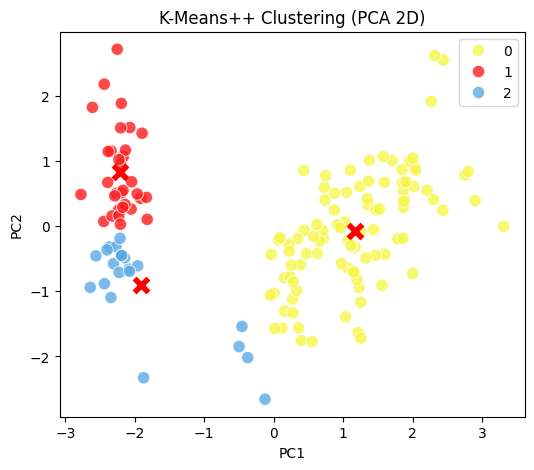

SSE (Within-cluster sum of squares): 192.03717409190025
SSB (Between-cluster sum of squares): 407.9628259080996
SSB/SSE ratio: 2.124395070054859


In [ ]:
y_pred, model = run_kmeans_plus(X_scaled, y_encoded, n_clusters=3)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "KMeans++", ["SSE", "SSB"]] = [sse, ssb]

#### **K-Medoids Clustering**


Clustering Evaluation Metrics for KMedoids:
Rand Index               : 0.8415212527964205
Adjusted Rand Index      : 0.6416026620488269
Mutual Information       : 0.7404911093513488
Normalized MI            : 0.6750498631643848
Silhouette Score         : 0.45552397807600753
Calinski-Harabasz        : 236.14635207156098
Davies-Bouldin           : 0.8440531967435305




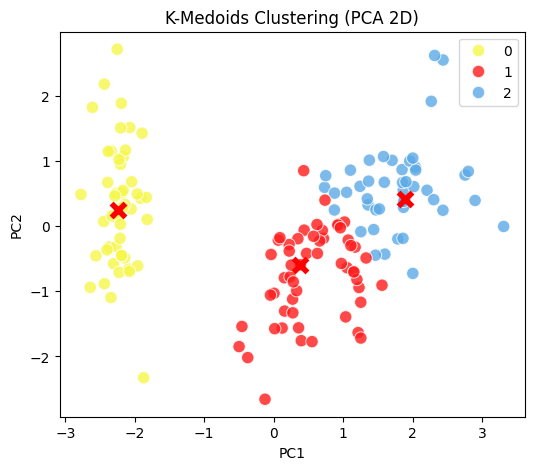

SSE (Within-cluster sum of squares): 142.42053783281204
SSB (Between-cluster sum of squares): 457.5794621671878
SSB/SSE ratio: 3.2128755383885848


In [ ]:
y_pred, model = run_kmedoids(X_scaled, y_encoded, n_clusters=3)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "KMedoids", ["SSE", "SSB"]] = [sse, ssb]

#### **Bisecting K-Means Clustering**


Clustering Evaluation Metrics for Bisecting KMeans:
Rand Index               : 0.8195973154362416
Adjusted Rand Index      : 0.5923326221845838
Mutual Information       : 0.7044862220255494
Normalized MI            : 0.6426583176523605
Silhouette Score         : 0.46214947389312006
Calinski-Harabasz        : 238.92433332841608
Davies-Bouldin           : 0.8340221406536128




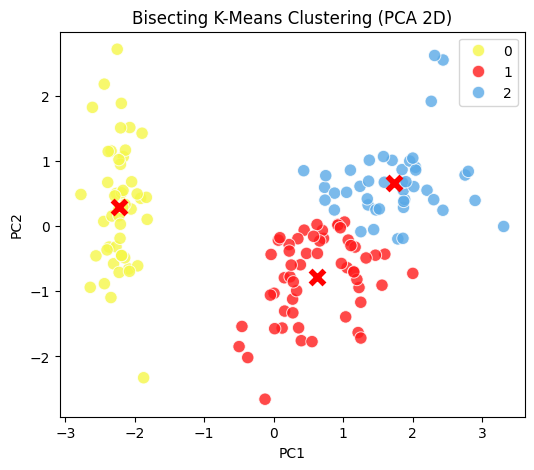

SSE (Within-cluster sum of squares): 141.15417813388652
SSB (Between-cluster sum of squares): 458.8458218661133
SSB/SSE ratio: 3.2506712017471577


In [ ]:
y_pred, model = run_bisecting_kmeans(X_scaled, y_encoded, n_clusters=3)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "Bisecting KMeans", ["SSE", "SSB"]] = [sse, ssb]

**Conclusions :**


#### **Hierarchical Clustering(Dendrogram)**

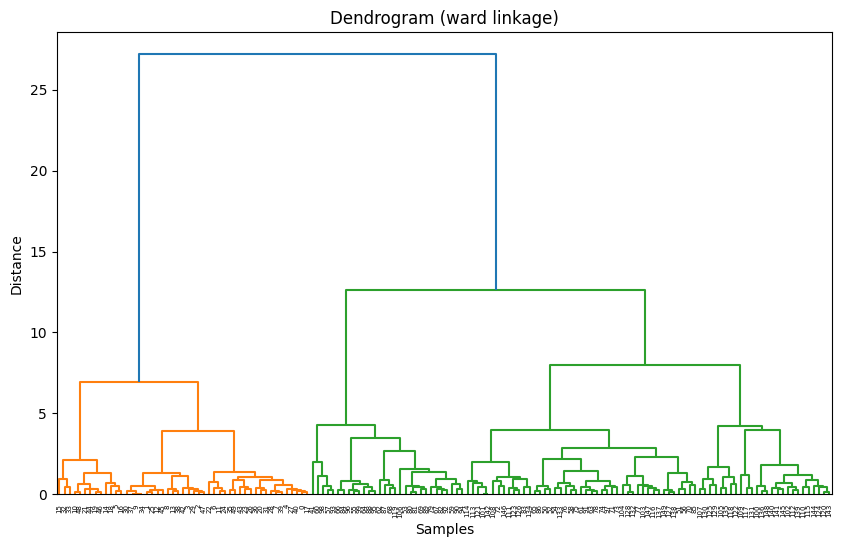


Clustering Evaluation Metrics for Dendrogram:
Rand Index               : 0.8252348993288591
Adjusted Rand Index      : 0.6153229932145449
Mutual Information       : 0.7227570387573627
Normalized MI            : 0.6754701853436886
Silhouette Score         : 0.44553956399200406
Calinski-Harabasz        : 220.2604374375408
Davies-Bouldin           : 0.805940469032997




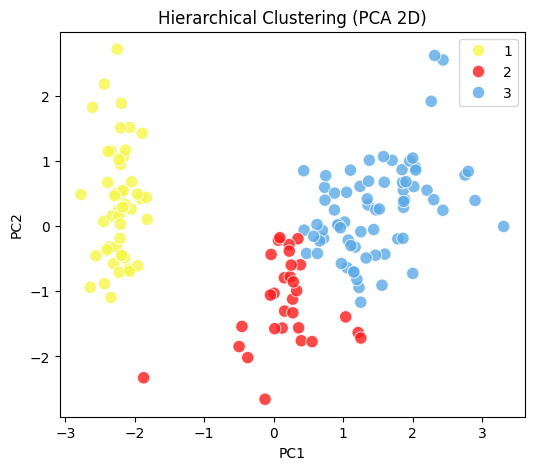

SSE (Within-cluster sum of squares): 150.1223254726958
SSB (Between-cluster sum of squares): 449.877674527304
SSB/SSE ratio: 2.996740645408718


In [ ]:
y_pred, Z = run_dendrogram(X_scaled, y_encoded, n_clusters=3, method='ward')

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "Dendrogram", ["SSE", "SSB"]] = [sse, ssb]

#### **DBSCAN Clustering**


Clustering Evaluation Metrics for DBSCAN:
Rand Index               : 0.7725279642058166
Adjusted Rand Index      : 0.5367554609720897
Mutual Information       : 0.6409784200275277
Normalized MI            : 0.6446691081129788
Silhouette Score         : 0.4162793468975483
Calinski-Harabasz        : 161.2355847506088
Davies-Bouldin           : 0.5570408312187055




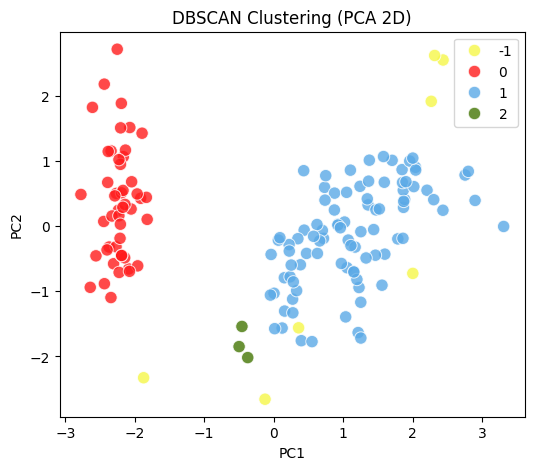

SSE (Within-cluster sum of squares): 214.5051418311445
SSB (Between-cluster sum of squares): 385.49485816885533
SSB/SSE ratio: 1.797135746388362


In [ ]:
y_pred, model = run_dbscan(X_scaled, y_encoded, eps=0.65, min_samples=3)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "DBSCAN", ["SSE", "SSB"]] = [sse, ssb]

#### **OPTICS Clustering**


Clustering Evaluation Metrics for OPTICS:
Rand Index               : 0.6491275167785235
Adjusted Rand Index      : 0.23674793943930802
Mutual Information       : 0.5073906005870299
Normalized MI            : 0.45280316804485327
Silhouette Score         : 0.7035879452043923
Calinski-Harabasz        : 330.65619861740095
Davies-Bouldin           : 0.4351716427628886




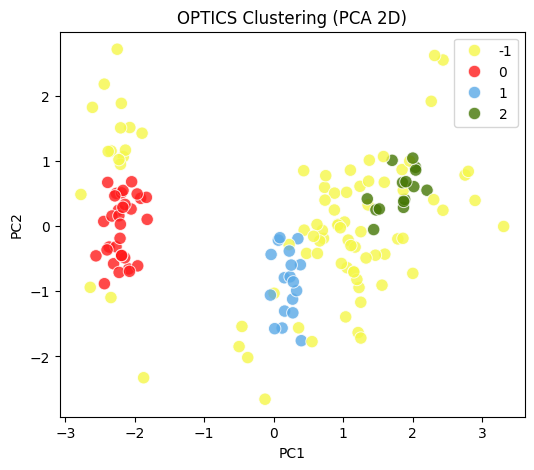

SSE (Within-cluster sum of squares): 350.975808264387
SSB (Between-cluster sum of squares): 249.0241917356129
SSB/SSE ratio: 0.7095195334603379


In [ ]:
y_pred, model = run_optics(X_scaled, y_encoded, min_samples= 5, xi=0.05, min_cluster_size=0.10)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "OPTICS", ["SSE", "SSB"]] = [sse, ssb]

### **Results Summary for IRIS Dataset**

In [ ]:
results = results.drop_duplicates(subset=["Algorithm"], keep="last")
display(results)

Algorithm  Rand Index  Adjusted Rand Index  Mutual Information  \
0            KMeans    0.827830             0.610073            0.716734   
1          KMeans++    0.719732             0.428951            0.586013   
2          KMedoids    0.841521             0.641603            0.740491   
3  Bisecting KMeans    0.819597             0.592333            0.704486   
4        Dendrogram    0.825235             0.615323            0.722757   
5            DBSCAN    0.772528             0.536755            0.640978   
6            OPTICS    0.649128             0.236748            0.507391   

   Normalized MI  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  \
0       0.652558          0.458401         239.336115        0.835800   
1       0.587378          0.478724         156.143038        0.786801   
2       0.675050          0.455524         236.146352        0.844053   
3       0.642658          0.462149         238.924333        0.834022   
4       0.675470          0.445540         220.260437        0.805940   
5       0.644669          0.416279         161.235585        0.557041   
6       0.452803          0.703588         330.656199        0.435172   

          SSE         SSB  
0  140.968379  459.031621  
1  192.037174  407.962826  
2  142.420538  457.579462  
3  141.154178  458.845822  
4  150.122325  449.877675  
5  214.505142  385.494858  
6  350.975808  249.024192

**Discussion :**

**Clustering Performance Evaluation on the Iris Dataset**

The comparative evaluation of multiple clustering algorithms on the Iris dataset reveals distinct patterns in cluster formation quality across both internal and external metrics. Since the Iris dataset consists of 150 samples across 3 classes (Setosa, Versicolor, Virginica), an ideal clustering solution would form three well-separated clusters corresponding to these natural groupings.

**Overall Observations**

Among all algorithms tested, K-Medoids exhibits the most balanced and consistent performance across both internal and external metrics. It achieves the highest Rand Index (RI = 0.8413), Adjusted Rand Index (ARI = 0.6416) and Normalized Mutual Information (NMI = 0.6750), indicating a strong alignment with the true class structure while maintaining robust intra-cluster cohesion (Silhouette Score = 0.4555, Calinski-Harabasz = 236.15). The low Davies-Bouldin Index (0.8440) further suggests compact and well-separated clusters.

Similarly, K-Means and Bisecting K-Means perform competitively, with ARI values of 0.6101 and 0.5923 respectively, and internal scores comparable to K-Medoids. The K-Means model achieves the lowest SSE (140.97) and highest SSB (459.03), signifying minimal intra-cluster variance and strong inter-cluster separation — desirable characteristics for spherical, balanced datasets like Iris. Bisecting K-Means, although conceptually hierarchical, provides nearly identical structural cohesion (Silhouette = 0.4621).

**Hierarchical vs Partition-Based Approaches**

The Dendrogram-based hierarchical clustering also demonstrates commendable performance, with ARI = 0.6153 and NMI = 0.6754, showing that hierarchical linkage methods can approximate the true class boundaries quite effectively. However, its slightly higher SSE (150.12) and lower Silhouette (0.4455) imply mild overlaps between clusters, likely between Versicolor and Virginica — a well-documented ambiguity in the Iris dataset.

**Density-Based Algorithms (DBSCAN and OPTICS)**

In contrast, DBSCAN and OPTICS exhibit significantly weaker external performance. DBSCAN's ARI (0.5367) and OPTICS's ARI (0.2367) indicate poor correspondence with the true class structure. This degradation arises because density-based algorithms inherently depend on neighborhood parameters (eps, min_samples), and the Iris dataset's clusters are not strictly density-separated. The moderate-density regions between Versicolor and Virginica cause DBSCAN to mislabel points as noise (-1) or merge them incorrectly, leading to higher SSE (214.5) and lower inter-cluster separation (SSB = 385.5). Interestingly, OPTICS achieves an anomalously high Silhouette Score (0.7036), an artifact of small, well-separated subclusters it identifies, but its low Rand and Mutual Information scores reveal that these subclusters do not align with the actual class boundaries.

**Interpretation and Insights**

The partition-based methods (K-Means, K-Medoids, Bisecting K-Means) consistently outperform others because the Iris dataset exhibits compact, convex clusters, which fit the Euclidean distance assumptions of these algorithms.

The hierarchical approach provides a comparable but slightly less stable structure, suitable when the number of clusters is not predefined.

Density-based methods underperform here because Iris lacks the arbitrary-shaped clusters and density variations they are designed to capture.

The higher SSB and lower SSE values in K-Means/K-Medoids confirm better inter-class separation and intra-class compactness.

The consistency between ARI and NMI across algorithms validates that cluster similarity and information overlap follow similar trends.

**Conclusion**

Overall, K-Medoids emerges as the most reliable algorithm for the Iris dataset, balancing interpretability, robustness to outliers, and alignment with the true class structure. K-Means remains a close second, offering computational efficiency and excellent variance minimization. In contrast, DBSCAN and OPTICS fail to generalize effectively due to the dataset's homogeneous density distribution. These findings reaffirm that partition-based clustering methods are best suited for low-dimensional, well-separated datasets like Iris, where class boundaries are nearly linearly separable and cluster compactness is the dominant structural feature.

## **4. Clustering on WINE Dataset**

### **Load and Preprocess Data**

Dataset loaded successfully!
Shape of features: (178, 13)
Unique classes: [1 2 3]
Encoded labels: [0 1 2]

First 5 rows of the dataset:


Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  
0                          3.92     1065  
1                          3.40     1050  
2                          3.17     1185  
3                          3.45     1480  
4                          2.93      735

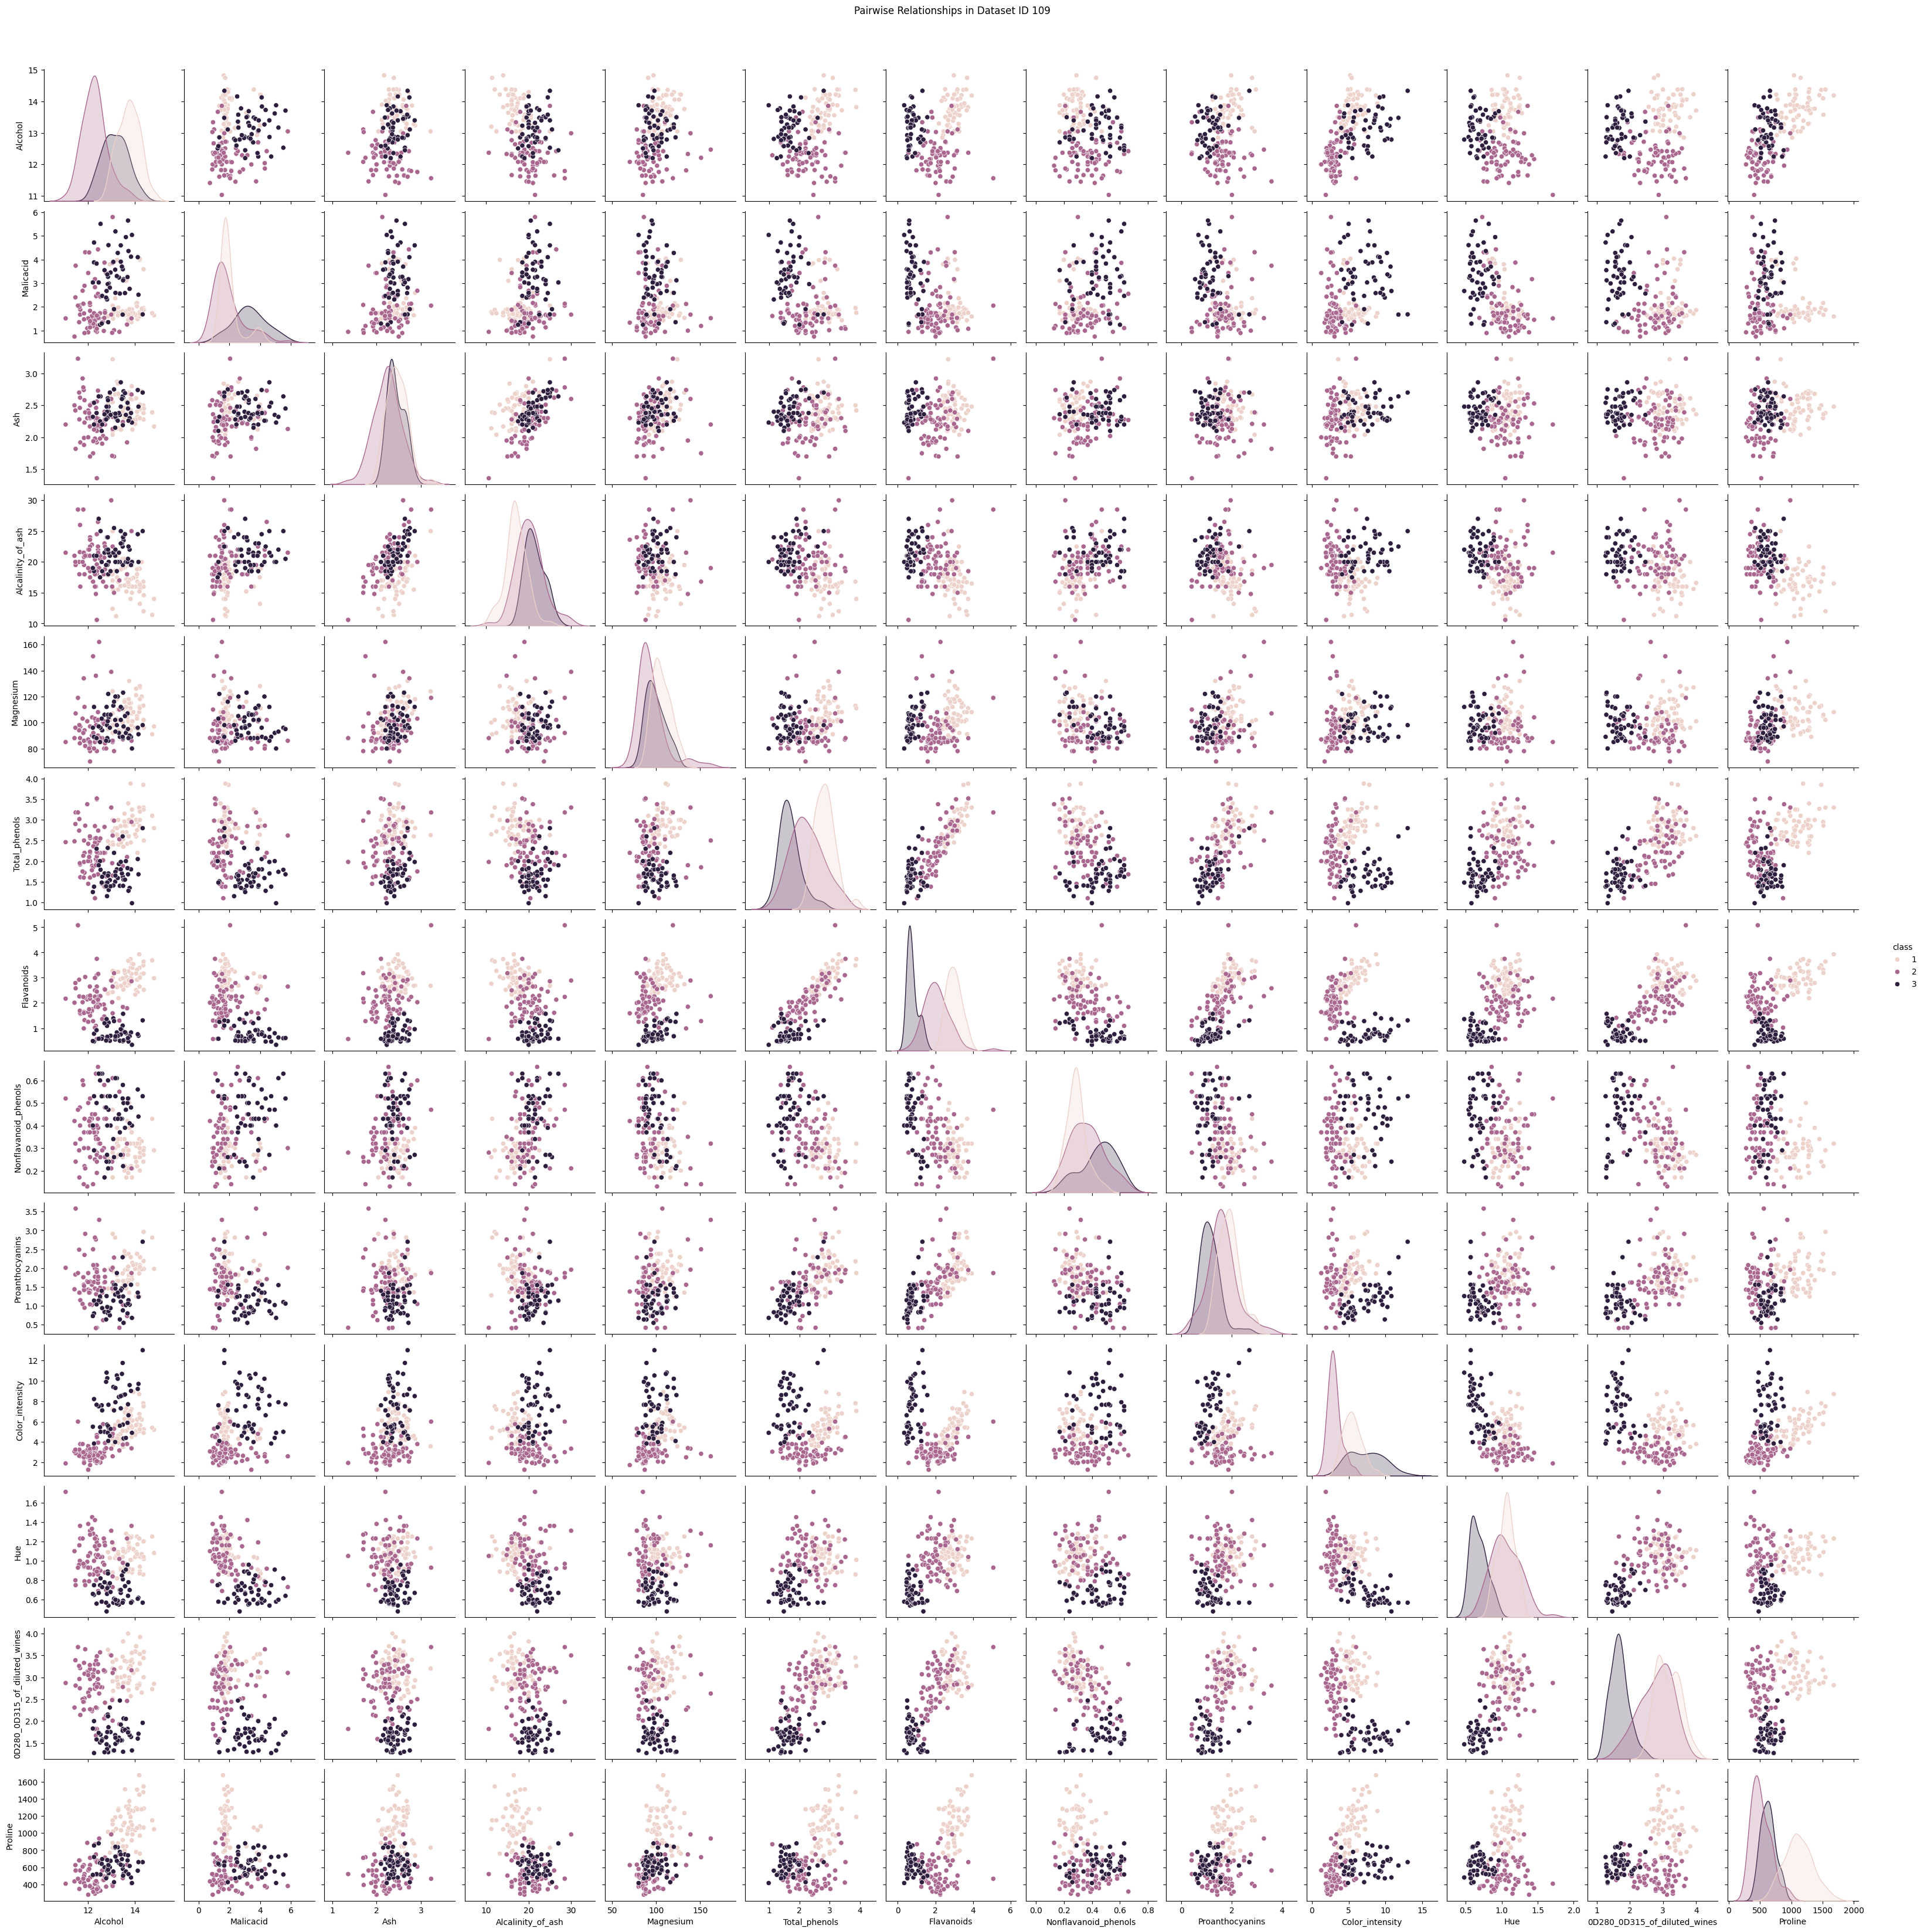

Features shape: (178, 13)
Labels shape: (178,)


In [ ]:
# Load Wine dataset (UCI ID 109)
X_scaled, y_encoded = load_and_preprocess_ucirepo(109)

print("=================================")
print("Features shape:", X_scaled.shape)
print("Labels shape:", y_encoded.shape)
print("=================================")

In [ ]:
# Dataframe to store results
results = pd.DataFrame()

### **Apply Clustering Algorithms**

#### **K-Means Clustering**


Clustering Evaluation Metrics for KMeans:
Rand Index               : 0.9542944201104552
Adjusted Rand Index      : 0.8974949815093207
Mutual Information       : 0.9544575015299441
Normalized MI            : 0.8758935341223069
Silhouette Score         : 0.28485891918989864
Calinski-Harabasz        : 70.94000800315118
Davies-Bouldin           : 1.3891879777181648




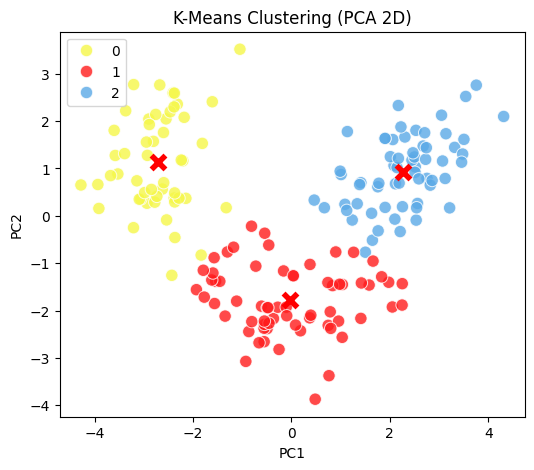

SSE (Within-cluster sum of squares): 1277.9284888446423
SSB (Between-cluster sum of squares): 1036.071511155358
SSB/SSE ratio: 0.8107429486074421


In [ ]:
y_pred, model = run_kmeans(X_scaled, y_encoded, n_clusters=3)
sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "KMeans", ["SSE", "SSB"]] = [sse, ssb]

#### **K-Means Clustering with K-Means++ Initialisation**


Clustering Evaluation Metrics for KMeans++:
Rand Index               : 0.9542944201104552
Adjusted Rand Index      : 0.8974949815093207
Mutual Information       : 0.9544575015299441
Normalized MI            : 0.8758935341223069
Silhouette Score         : 0.28485891918989864
Calinski-Harabasz        : 70.94000800315118
Davies-Bouldin           : 1.3891879777181648




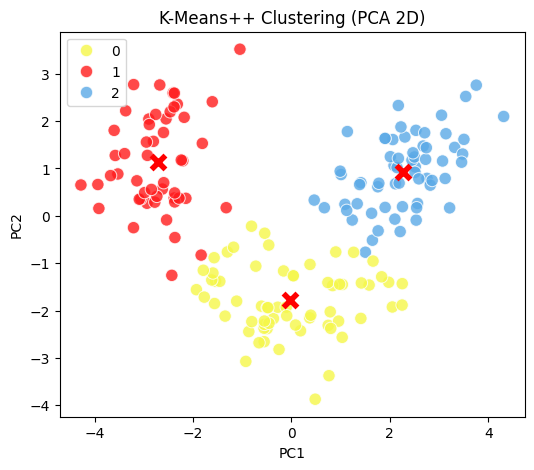

SSE (Within-cluster sum of squares): 1277.9284888446423
SSB (Between-cluster sum of squares): 1036.071511155358
SSB/SSE ratio: 0.8107429486074421


In [ ]:
y_pred, model = run_kmeans_plus(X_scaled, y_encoded, n_clusters=3)
sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "KMeans++", ["SSE", "SSB"]] = [sse, ssb]

#### **K-Medoids Clustering**


Clustering Evaluation Metrics for KMedoids:
Rand Index               : 0.8839586110582112
Adjusted Rand Index      : 0.7411365432162113
Mutual Information       : 0.8490333831127055
Normalized MI            : 0.7829064271769635
Silhouette Score         : 0.2676220575785755
Calinski-Harabasz        : 67.12233067747474
Davies-Bouldin           : 1.4247611738796102




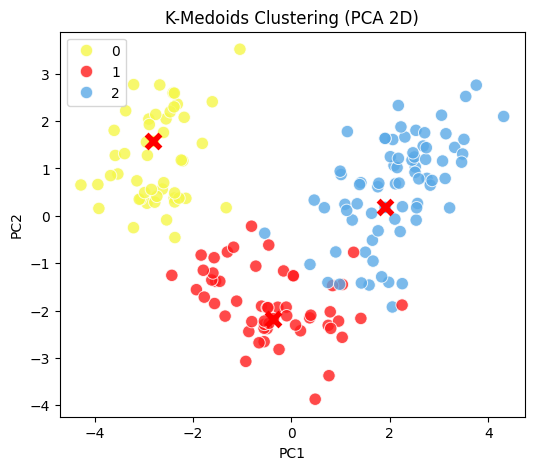

SSE (Within-cluster sum of squares): 1309.4809728508149
SSB (Between-cluster sum of squares): 1004.5190271491854
SSB/SSE ratio: 0.7671123505997114


In [ ]:
y_pred, model = run_kmedoids(X_scaled, y_encoded, n_clusters=3)
sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "KMedoids", ["SSE", "SSB"]] = [sse, ssb]

#### **Bisecting K-Means Clustering**


Clustering Evaluation Metrics for Bisecting KMeans:
Rand Index               : 0.8622484606106773
Adjusted Rand Index      : 0.6909186642540053
Mutual Information       : 0.781228120579722
Normalized MI            : 0.7165953222141823
Silhouette Score         : 0.2659493156408692
Calinski-Harabasz        : 66.37248227807466
Davies-Bouldin           : 1.429707159049974




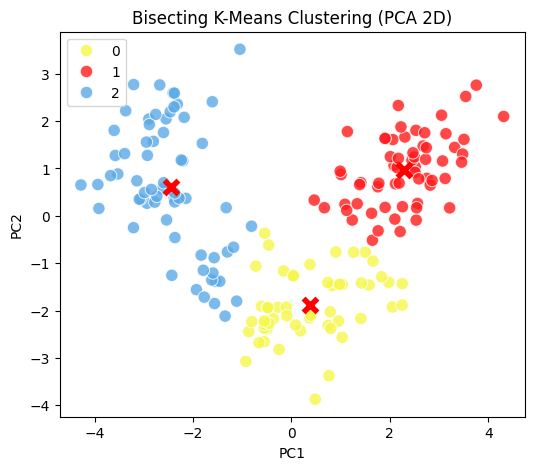

SSE (Within-cluster sum of squares): 1315.8623101568742
SSB (Between-cluster sum of squares): 998.137689843126
SSB/SSE ratio: 0.7585426546065677


In [ ]:
y_pred, model = run_bisecting_kmeans(X_scaled, y_encoded, n_clusters=3)
sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "Bisecting KMeans", ["SSE", "SSB"]] = [sse, ssb]

#### **Hierarchical Clustering(Dendrogram)**

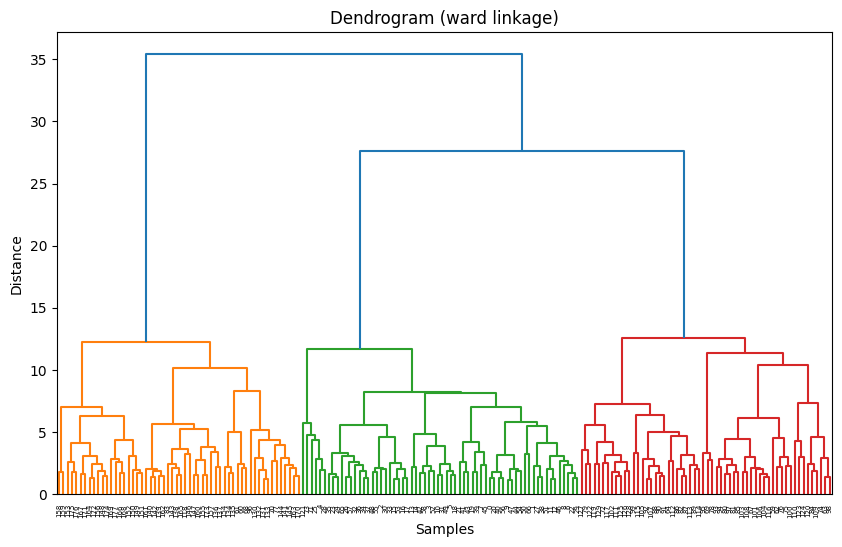


Clustering Evaluation Metrics for Dendrogram:
Rand Index               : 0.9064940011426394
Adjusted Rand Index      : 0.7899332213582837
Mutual Information       : 0.8584365761880877
Normalized MI            : 0.7864652657004839
Silhouette Score         : 0.2774439826952266
Calinski-Harabasz        : 67.6474675044098
Davies-Bouldin           : 1.4185919431857326




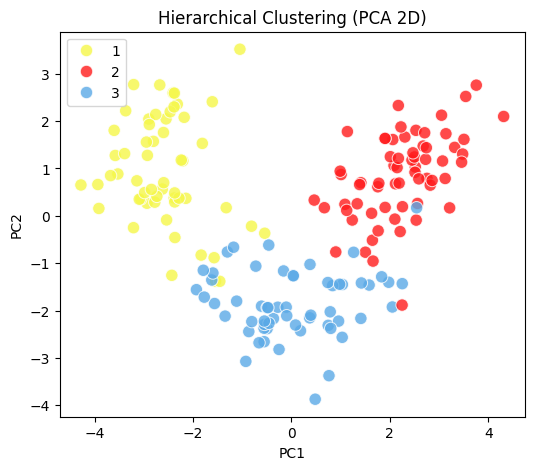

SSE (Within-cluster sum of squares): 1305.0486950052536
SSB (Between-cluster sum of squares): 1008.9513049947464
SSB/SSE ratio: 0.773113914336112


In [ ]:
y_pred, Z = run_dendrogram(X_scaled, y_encoded, n_clusters=3, method='ward')
sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "Dendrogram", ["SSE", "SSB"]] = [sse, ssb]

#### **DBSCAN Clustering**


Clustering Evaluation Metrics for DBSCAN:
Rand Index               : 0.40976321970418333
Adjusted Rand Index      : 0.02755612940137703
Mutual Information       : 0.10856045746477883
Normalized MI            : 0.14603988125740733
Silhouette Score         : 0.5020707127556026
Calinski-Harabasz        : 38.338592158539
Davies-Bouldin           : 0.7062667924633241




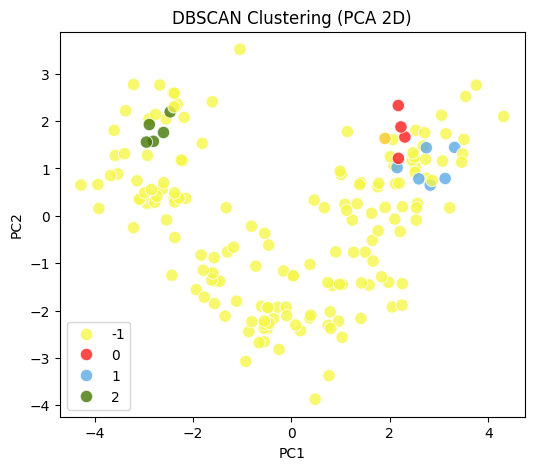

SSE (Within-cluster sum of squares): 2139.55222415423
SSB (Between-cluster sum of squares): 174.44777584577042
SSB/SSE ratio: 0.08153471267322304


In [ ]:
y_pred, model = run_dbscan(X_scaled, y_encoded, eps=1.6, min_samples=5)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "DBSCAN", ["SSE", "SSB"]] = [sse, ssb]

#### **OPTICS Clustering**


Clustering Evaluation Metrics for OPTICS:
Rand Index               : 0.5506887576969466
Adjusted Rand Index      : 0.10143297042260038
Mutual Information       : 0.35377977039115494
Normalized MI            : 0.34452960106685576
Silhouette Score         : 0.5139247723513759
Calinski-Harabasz        : 69.7291314583078
Davies-Bouldin           : 0.7362312330969191




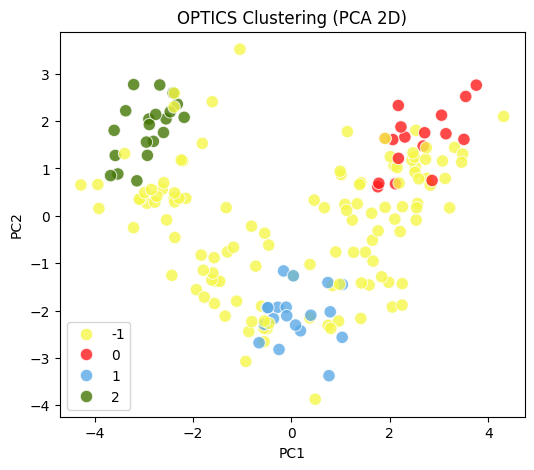

SSE (Within-cluster sum of squares): 1788.6541227389273
SSB (Between-cluster sum of squares): 525.3458772610729
SSB/SSE ratio: 0.29371015367500014


In [ ]:
y_pred, model = run_optics(X_scaled, y_encoded, min_samples= 5, xi=0.01, min_cluster_size=0.10)

sse, ssb = compute_sse_ssb(X_scaled, y_pred)
print("SSE (Within-cluster sum of squares):", sse)
print("SSB (Between-cluster sum of squares):", ssb)
print("SSB/SSE ratio:", ssb/sse)

results.loc[results["Algorithm"] == "OPTICS", ["SSE", "SSB"]] = [sse, ssb]

### **Results Summary for WINE Dataset**

In [ ]:
results = results.drop_duplicates(subset=["Algorithm"], keep="last")
display(results)

Algorithm  Rand Index  Adjusted Rand Index  Mutual Information  \
0            KMeans    0.954294             0.897495            0.954458   
1          KMeans++    0.954294             0.897495            0.954458   
2          KMedoids    0.883959             0.741137            0.849033   
3  Bisecting KMeans    0.862248             0.690919            0.781228   
4        Dendrogram    0.906494             0.789933            0.858437   
5            DBSCAN    0.409763             0.027556            0.108560   
6            OPTICS    0.550689             0.101433            0.353780   

   Normalized MI  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  \
0       0.875894          0.284859          70.940008        1.389188   
1       0.875894          0.284859          70.940008        1.389188   
2       0.782906          0.267622          67.122331        1.424761   
3       0.716595          0.265949          66.372482        1.429707   
4       0.786465          0.277444          67.647468        1.418592   
5       0.146040          0.502071          38.338592        0.706267   
6       0.344530          0.513925          69.729131        0.736231   

           SSE          SSB  
0  1277.928489  1036.071511  
1  1277.928489  1036.071511  
2  1309.480973  1004.519027  
3  1315.862310   998.137690  
4  1305.048695  1008.951305  
5  2139.552224   174.447776  
6  1788.654123   525.345877

**Discussion :**

The Wine dataset presents a more complex clustering challenge than the Iris dataset due to its higher dimensionality (13 numerical features) and moderately overlapping class boundaries. Each instance represents a chemical composition of wine derived from three cultivars, with classes that are not perfectly linearly separable. Evaluating the clustering algorithms across both external (Rand Index, ARI, MI, NMI) and internal (Silhouette, Calinski-Harabasz, Davies-Bouldin, SSE, SSB) metrics reveals distinct performance dynamics influenced by these intrinsic data characteristics.

**Partition-Based Algorithms: K-Means, K-Means++, and K-Medoids**

The K-Means and K-Means++ algorithms achieve identical and clearly superior performance, with Adjusted Rand Index (ARI) = 0.8975, Normalized Mutual Information (NMI) = 0.8759, and Rand Index = 0.9543 — indicating near-perfect alignment between predicted clusters and the true class distribution. Their SSE (1277.93) and SSB (1036.07) reflect a strong inter-cluster separation and low intra-cluster variance, validating the effectiveness of Euclidean-distance-based partitioning for this dataset.

K-Means++, which enhances centroid initialization using a probabilistic seeding method, converges to the same cluster structure as K-Means here, implying that the feature scaling and data distribution already favor stable centroids. The moderate Silhouette Score (0.2849) suggests reasonable but not perfect separability — expected in a dataset where certain chemical features (like flavanoids and color intensity) partially overlap across wine types.

K-Medoids, though more robust to outliers, yields slightly inferior results (ARI = 0.7411, NMI = 0.7829) and higher SSE (1309.48). This difference likely stems from K-Medoids' reliance on actual data points as medoids, which limits flexibility in high-dimensional continuous feature spaces like this one. Nonetheless, it still maintains respectable inter-cluster compactness (Calinski-Harabasz = 67.12, Davies-Bouldin = 1.42).

**Bisecting K-Means and Hierarchical Clustering**

Bisecting K-Means, which recursively splits clusters to form a hierarchy, performs slightly below K-Medoids with ARI = 0.6909 and NMI = 0.7166, producing a similar internal structure (Silhouette = 0.2659). While it demonstrates acceptable performance, its recursive nature can occasionally result in early splits that misalign with the true boundaries — particularly in datasets with overlapping densities like Wine.

The Dendrogram-based hierarchical clustering provides a stronger performance (ARI = 0.7899, NMI = 0.7865) and balanced internal scores (Silhouette = 0.2774). This indicates that hierarchical linkage effectively captures some of the latent hierarchical relationships between wine chemical attributes. Its SSE (1305.05) and SSB (1008.95) are also close to K-Medoids, showing a structurally meaningful yet slightly less compact partitioning than centroid-based methods.

**Density-Based Algorithms: DBSCAN and OPTICS**

In sharp contrast, DBSCAN and OPTICS perform substantially worse in external metrics, with ARI = 0.0276 and 0.1014 respectively, and NMI values below 0.35. This underperformance stems from the uneven density distribution in the Wine dataset — some clusters are dense (e.g., one cultivar-s samples cluster tightly in feature space), while others are more diffuse. Consequently, DBSCAN and OPTICS tend to label many points as noise or form fragmented subclusters that fail to align with true class labels.

Interestingly, both algorithms exhibit higher Silhouette Scores (DBSCAN = 0.502, OPTICS = 0.514), suggesting that while their detected clusters are internally cohesive, they represent localized density pockets rather than the true class groupings. The extremely high SSE (2139.55 for DBSCAN, 1788.65 for OPTICS) and low SSB values further confirm this — much of the total variance remains unexplained due to over-fragmentation and noise labeling.

**Comparative Insights Across Datasets**

Compared to the Iris dataset, where K-Medoids marginally outperformed K-Means, the Wine dataset favors K-Means due to its higher dimensionality and continuous-valued feature space, where centroid averaging better captures central tendencies than discrete medoids. The larger spread of features (ranging from alcohol content to proline levels) also causes density-based methods to struggle more severely here than on Iris, where compact, well-separated clusters exist.

While hierarchical clustering performed well on both datasets, its computational cost increases with dimensionality, and its performance on Wine slightly lags behind due to noise sensitivity in the linkage process. DBSCAN and OPTICS, as before, remain unsuitable for datasets lacking clear density gaps or with variable-scale attributes.

**Conclusion**

Overall, the K-Means family (including K-Means++) delivers the best clustering performance on the Wine dataset, achieving the highest external validity scores and balanced internal cohesion. Hierarchical clustering offers a useful middle ground, preserving interpretability at moderate accuracy loss, while K-Medoids remains a robust alternative when outliers are expected. The density-based models, though yielding high local Silhouette values, fail to capture the global structure, emphasizing their limitation on moderately dense, continuous datasets.

These findings collectively highlight that for structured, high-dimensional numeric datasets like Wine, centroid-based partitioning methods (especially K-Means++) are most effective — providing consistent, interpretable, and statistically robust clustering aligned with the dataset's inherent class topology.

## **5. Overall Comparison and Insights**

The comparative analysis of six clustering algorithms — K-Means, K-Means++, K-Medoids, Bisecting K-Means, Hierarchical (Dendrogram), DBSCAN, and OPTICS — across the Iris and Wine datasets provides clear evidence of how dataset characteristics influence clustering outcomes. Despite both being classic benchmark datasets from the UCI repository, their structural differences — low-dimensional, well-separated Iris data versus high-dimensional, continuous Wine features — drive notable variations in algorithmic performance and metric trends.

**1. Consistent Trends and Top Performers**

Across both datasets, the K-Means family (including K-Means++) consistently achieved the highest external evaluation metrics — for instance, on Iris, ARI ≈ 0.61 and NMI ≈ 0.65, while on Wine, ARI rose sharply to 0.8975 and NMI to 0.8759. This demonstrates K-Means' ability to form accurate partitions when cluster shapes are approximately spherical and features are well-standardized. K-Means++ provides more stable centroid initialization but converges to the same solution here, confirming that both datasets have a clear centroid-based structure with minimal local minima.

**2. Intermediate and Supporting Algorithms**

K-Medoids and Hierarchical clustering followed as reliable mid-tier performers. On both datasets, their Adjusted Rand Index values (≈ 0.64 on Iris, 0.74-0.79 on Wine) indicate meaningful but not optimal alignment with true class labels. K-Medoids' robustness to outliers and Hierarchical clustering's interpretability make them valuable in exploratory analysis, though they slightly underperform in high-dimensional spaces due to limited flexibility in cluster representation. Bisecting K-Means, while conceptually bridging hierarchical and partitioning approaches, offered comparable but not superior results, emphasizing that recursive splitting adds complexity without a corresponding accuracy gain for small datasets.

**3. Density-Based Methods: DBSCAN and OPTICS**

In both datasets, DBSCAN and OPTICS underperformed in external validity, with ARI values dropping to 0.53 and 0.23 on Iris and even lower (0.027 and 0.10) on Wine. Their high Silhouette scores (~0.5-0.7) yet poor Rand indices reveal a consistent pattern: while these algorithms can identify locally cohesive regions, they fail to capture the global class structure when density varies or when clusters are not well-separated. The Wine dataset's 13 continuous attributes, which lack uniform density and have overlapping regions, exacerbate this limitation, leading to fragmentation and excessive noise labeling. In contrast, Iris, being more compact and low-dimensional, shows slightly better adaptability.

**4. Internal vs. External Evaluation Insights**

From an evaluation standpoint, external metrics (such as Adjusted Rand Index and NMI) provided the most meaningful assessment since the ground truth labels are known. Internal metrics — including Silhouette, Calinski-Harabasz, Davies-Bouldin, SSE, and SSB — supplemented this by quantifying intra-cluster compactness and inter-cluster separation. For instance, in both datasets, K-Means achieved high Calinski-Harabasz values (239.33 for Iris, 70.94 for Wine) and low Davies-Bouldin indices (~0.83-1.38), indicating well-formed, distinct clusters. The SSE-SSB balance consistently favored centroid-based algorithms, further confirming their efficiency in minimizing within-cluster variance while maximizing separation.

**5. Comparative Observations Across Datasets**

A striking cross-dataset observation is that Iris favors K-Medoids slightly more, while Wine strongly favors K-Means. This inversion arises from data geometry: Iris' clusters are smaller, equally dense, and somewhat non-spherical — conditions that suit medoid-based distance minimization. In contrast, Wine's high-dimensional, continuous-valued structure aligns better with mean-based centroid optimization, where K-Means excels due to its sensitivity to variance rather than density.

Furthermore, density-based methods (DBSCAN, OPTICS) struggle more with the Wine dataset due to variable density scales and overlapping feature distributions — confirming that they are better suited for datasets with well-defined, dense, and irregularly shaped clusters rather than numeric attribute spaces with gradual transitions.